In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Monte-Carlo Control

In [20]:
class Env:
    def __init__(self):
        super(Env, self).__init__()
        self.dealer_first = np.random.randint(1, 11)
        self.player_sum = np.random.randint(1, 11)
        self.is_end = False
        
    def step(self, action):
        if action == 0:
            if (np.random.random() * 3) < 1:
                self.player_sum -= np.random.randint(1, 11)
            else:
                self.player_sum += np.random.randint(1, 11)
            if (self.player_sum < 1) or (self.player_sum > 21):
                self.is_end = True
                return -1
            return 0
        elif action == 1:
            self.is_end = True
            dealer_sum = self.dealer_first
            while dealer_sum < 17:
                if (np.random.random() * 3) < 1:
                    dealer_sum -= np.random.randint(1, 11)
                else:
                    dealer_sum += np.random.randint(1, 11)
                if (dealer_sum < 1) or (dealer_sum > 21):
                    return 1
            if (dealer_sum > 21) or (self.player_sum > dealer_sum):
                return 1
            elif dealer_sum > self.player_sum:
                return -1
            elif dealer_sum == self.player_sum:
                return 0
            
    def end(self):
        return self.is_end
    
    def state(self):
        return [self.dealer_first, self.player_sum]

In [48]:
def epsilon_greedy(N0, N, Q, state):
    epsilon = N0 / (N0 + np.sum(N[state[0] - 1, state[1] - 1, :]))
    if np.random.random() > epsilon:
        action = np.argmax(Q[state[0] - 1, state[1] - 1])
    else:
        action = np.random.randint(0, 2)
    return action

def monte_carlo_control(max_episodes, gamma, N0):
    Q = np.random.random((10, 21, 2)) * 0.1
    N = np.zeros((10, 21, 2))
    for i in range(max_episodes):
        episode = Env()
        history = []
        while not episode.end():
            [dealer_first, player_sum] = episode.state()
            action = epsilon_greedy(N0, N, Q, [dealer_first, player_sum])
            N[dealer_first - 1, player_sum - 1, action] += 1
            reward = episode.step(action)
            history.append(([dealer_first, player_sum], action, reward))
        Gt = 0
        for j, ([dealer_first, player_sum], action, reward) in enumerate(reversed(history)):
            Gt = Gt * gamma + reward
            Q[dealer_first - 1, player_sum - 1, action] += (Gt - Q[dealer_first - 1, player_sum - 1, action]) /\
                                                            N[dealer_first - 1, player_sum - 1, action]
    return Q

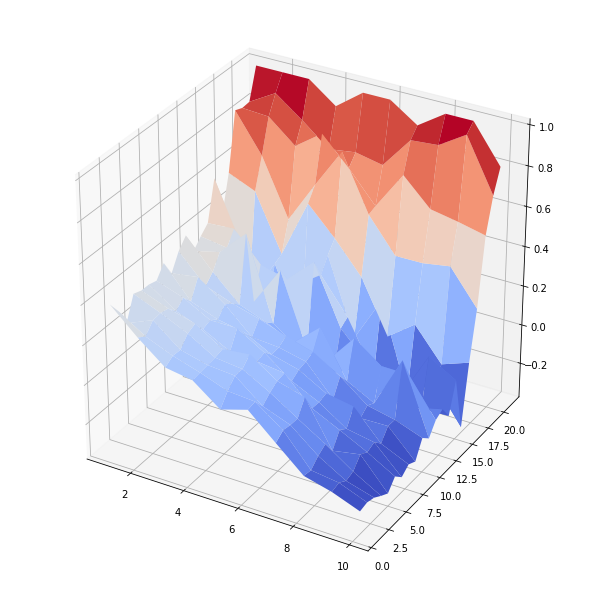

In [49]:
N0 = 100
gamma = 1
max_episodes = 100000
Q = monte_carlo_control(max_episodes, gamma, N0)
Vm = np.amax(Q, axis=2)
x = np.arange(1, 11)
y = np.arange(1, 22)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(x, y, Vm.T, rstride=1, cstride=1, cmap=cm.coolwarm)
plt.show()

In [17]:
Q.shape, Vm.shape, x.shape

((10, 21, 2), (10, 21), (21, 10))

# Temporal-Difference Control

SARSA

In [38]:
def sarsa(max_episodes, gamma, N0):
    Q = np.random.random((10, 21, 2)) * .1
    N = np.zeros((10, 21, 2))
    for i in range(max_episodes):
        episode = Env()
        state = episode.state()
        action = epsilon_greedy(N0, N, Q, state)
        while not episode.end():
            N[state[0] - 1, state[1] - 1, action] += 1
            reward = episode.step(action)
            next_Q = None
            old_state, old_action = state, action
            if episode.end():
                next_Q = 0.
            else:
                action = epsilon_greedy(N0, N, Q, episode.state())
                state = episode.state()
                next_Q = Q[state[0] - 1, state[1] - 1, action]
            alpha = 1 / N[old_state[0] - 1, old_state[1] - 1, old_action]
            Q[old_state[0] - 1, old_state[1] - 1, old_action] += alpha * (reward + gamma * next_Q -\
                                                                  Q[old_state[0] - 1, old_state[1] - 1, old_action])
    return Q

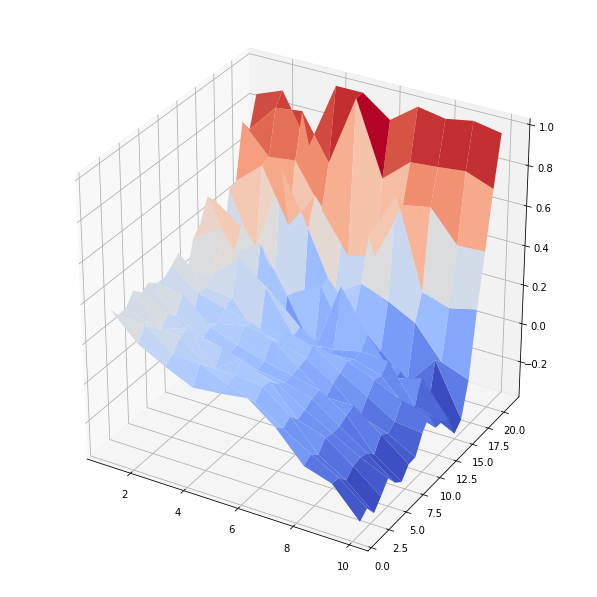

In [45]:
N0 = 100
gamma = 1
max_episodes = 100000
Q = sarsa(max_episodes, gamma, N0)
# print(Q.shape)
Vm = np.amax(Q, axis=2)
x = np.arange(1, 11)
y = np.arange(1, 22)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(x, y, Vm.T, rstride=1, cstride=1, cmap=cm.coolwarm)
plt.show()

SARSA($\lambda$)

In [51]:
def sarsa_lambda(max_episodes, gamma, N0, lambda_):
    Q = np.random.random((10, 21, 2)) * .1
    N = np.zeros((10, 21, 2))
    for i in range(max_episodes):
        episode = Env()
        E = np.zeros((10, 21, 2))
        state = episode.state()
        action = epsilon_greedy(N0, N, Q, state)
        while not episode.end():
            N[state[0] - 1, state[1] - 1, action] += 1
            reward = episode.step(action)
            next_Q = None
            old_state, old_action = state, action
            if episode.end():
                next_Q = 0.
            else:
                action = epsilon_greedy(N0, N, Q, episode.state())
                state = episode.state()
                next_Q = Q[state[0] - 1, state[1] - 1, action]
            alpha = 1 / N[old_state[0] - 1, old_state[1] - 1, old_action]
            delta = reward + gamma * next_Q - Q[old_state[0] - 1, old_state[1] - 1, old_action]
            E[old_state[0] - 1, old_state[1] - 1, old_action] += 1
            Q[old_state[0] - 1, old_state[1] - 1, old_action] += alpha * delta *\
                                                                 E[old_state[0] - 1, old_state[1] - 1, old_action]
            E[old_state[0] - 1, old_state[1] - 1, old_action] *= gamma * lambda_
    return Q

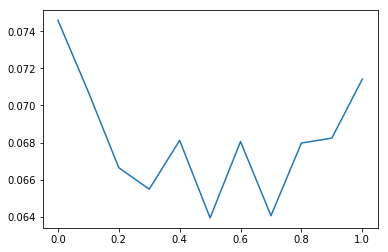

In [54]:
N0 = 100
gamma = 1
max_episodes = 10000
error = []
for lambda_ in np.arange(0, 1.1, 0.1):
    Q_estimate = sarsa_lambda(max_episodes, gamma, N0, lambda_)
    error.append(np.mean((Q - Q_estimate) ** 2))
plt.plot(np.arange(0, 1.1, 0.1), error)

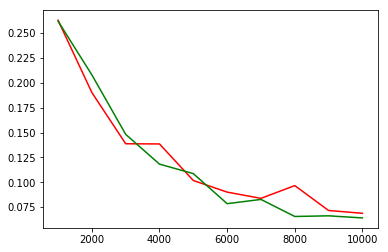

In [57]:
N0 = 100
gamma = 1
# max_episodes = 10000
error_lambda0 = []
error_lambda1 = []
for max_episodes in np.arange(1000, 11000, 1000):
    Q_estimate = sarsa_lambda(max_episodes, gamma, N0, 0)
    error_lambda0.append(np.mean((Q - Q_estimate) ** 2))
    Q_estimate = sarsa_lambda(max_episodes, gamma, N0, 1)
    error_lambda1.append(np.mean((Q - Q_estimate) ** 2))
plt.plot(np.arange(1000, 11000, 1000), error_lambda0, 'r')
plt.plot(np.arange(1000, 11000, 1000), error_lambda1, 'g')